In [1]:
import matplotlib.pyplot as plt
import numpy as np
from project.Urbano08.BiddingEnvironment import BiddingEnvironment
from project.Urbano08.Learner import Learner
import pandas as pd
from project.Urbano08.Optimizer import Optimizer

# EXPLORATION PHASE

In [2]:
n_obs = 40
n_obs_exploration = round(n_obs/3)
n_obs_exploitation = n_obs-n_obs_exploration
n_subcamp = 3
max_bid = 1
max_clicks = 100
n_arms = 11

bids = np.linspace(0, max_bid, n_arms)
print(bids)

total_click_each_day = pd.DataFrame(columns=['bid_sub1', 'bid_sub2', 'bid_sub3',"click1","click2","click3"])

noise_std = 6.0
env = BiddingEnvironment(bids,max_clicks,noise_std)

learners = []
for i in range(0, n_subcamp):
    learners.append(Learner(n_arms,bids))

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [3]:
for i in range(0, n_obs_exploration):
    clicks = []

    #Pull an arm for each sub-campaign:
    #It is pulled the arm belonging to the sub-campaign (i%3) which has the maximum variance
    #For the other 2 sub-campaigns the arm is pulled randomly (s.t. the sum = maximum)
    ### N.B. This behaviour works only for arms linearly distributed  over the array_bids
    first = i % 3
    pulled = [0,0,0]
    pulled[first] = learners[first].pull_arm()
    pulled[(first + 1 )% 3] = np.random.randint(0,n_arms - pulled[first])
    pulled[(first + 2 )% 3] = n_arms - pulled[first] - pulled[(first + 1 )% 3] - 1

    clicks = env.round(pulled[0],pulled[1],pulled[2])


    for x in range(0,n_subcamp):
        learners[x].update(pulled[x], clicks[x])
    total_click_each_day = total_click_each_day.append({
        'bid_sub1':pulled[0],
        'bid_sub2':pulled[1],
        'bid_sub3':pulled[2],
        "click1":clicks[0],
        "click2":clicks[1],
        "click3":clicks[2]
    }, ignore_index=True)


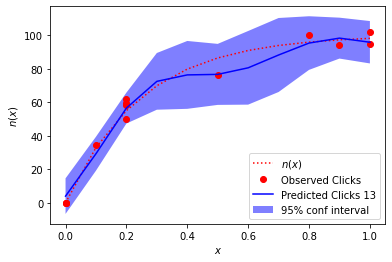

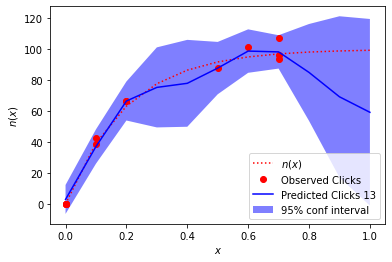

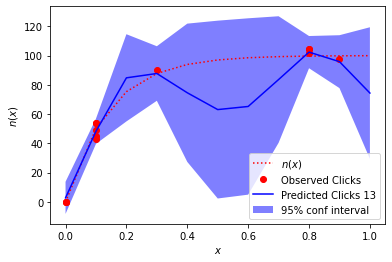

In [4]:
for s in range(0,n_subcamp):
    learners[s].plot(env.subs[s])

# EXPLOITATION PHASE


In [5]:
table_all_Subs = np.ndarray(shape=(0,len(bids)), dtype=float)
for l in learners:
    table_all_Subs = np.append(table_all_Subs,np.atleast_2d(l.means.T),0)

print(table_all_Subs)
print(Optimizer.fit_table(table_all_Subs))



[[  3.93326203  29.28027916  56.52837553  72.48563239  76.33913221
   76.64625539  80.57146114  88.22417661  95.35574322  98.30554026
   95.84151754]
 [  2.86428515  37.08765939  66.50655454  75.3132099   77.95737107
   87.79831645  98.80223247  98.26656622  84.99282377  69.23137582
   59.21001341]
 [  2.76002599  48.24961298  84.76987818  87.73187008  74.55984198
   63.07164889  65.19723461  83.60229594 102.33397902  95.82134758
   74.36645833]]
([3, 5, 2], 245.0538270143988)


In [ ]:
for i in range(0, n_obs_exploitation):
    clicks = []

    pulled = Optimizer.fit_table(table_all_Subs)[0]

    clicks = env.round(pulled[0],pulled[1],pulled[2])


    for x in range(0,n_subcamp):
        learners[x].update(pulled[x], clicks[x])
    total_click_each_day = total_click_each_day.append({
        'bid_sub1':pulled[0],
        'bid_sub2':pulled[1],
        'bid_sub3':pulled[2],
        "click1":clicks[0],
        "click2":clicks[1],
        "click3":clicks[2]
    }, ignore_index=True)

    table_all_Subs = np.ndarray(shape=(0,len(bids)), dtype=float)
    for l in learners:
        table_all_Subs = np.append(table_all_Subs,np.atleast_2d(l.means.T),0)


In [ ]:
for s in range(0,n_subcamp):
    learners[s].plot(env.subs[s])


Applicare l'algoritmo della tabella alla curva ideale per trovare l'optimal
sottrarre i reward (somma dei click) di ogni turno dall'optimal trovato
Plottare il regret sommando le differenze

## Regret Computation


In [ ]:
all_optimal_subs = np.ndarray(shape=(0,len(bids)), dtype=float)
for i in range(0,n_subcamp):
    all_optimal_subs = np.append(all_optimal_subs,np.atleast_2d(env.subs[i](bids)),0)

print(all_optimal_subs)
print(Optimizer.fit_table(all_optimal_subs))


In [ ]:
# list of the collected reward
rewards_per_experiment = []
opt = Optimizer.fit_table(all_optimal_subs)[1]
print(opt)

for i in range(0,n_obs):
    num_clicks_day_i = total_click_each_day.values[i][3]  \
                       + total_click_each_day.values[i][4] \
                       + total_click_each_day.values[i][5]
    rewards_per_experiment.append(num_clicks_day_i)

plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(opt - rewards_per_experiment, axis=0), 'r')
plt.show()


